In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings

from IPython.display import Audio
from scikitplot.metrics import plot_confusion_matrix, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

warnings.filterwarnings('ignore')

### Load Data (taken form marcus's code)

In [3]:
paths = []
labels = []

# Use os.walk to walk through the directory structure
for dirname, _, filenames in os.walk(r'data'):
    for filename in filenames:
        if filename == '.DS_Store':
            continue  # Skip this file
        # Construct the full file path
        full_path = os.path.join(dirname, filename)
        paths.append(full_path)
        
        # Extract label and gender from the directory name
        # Assumes the structure is data/label_gender/filename
        folder_name = os.path.basename(dirname)
        label = folder_name
        emotion = label.split('_')[0]
        labels.append(emotion.lower())

# Create a DataFrame with the collected data
df = pd.DataFrame({
    'file_path': paths,
    'label': labels,
})

# Display the first few rows of the DataFrame to verify
df.head()

,file_path,label
0,data\Angry_Female\anger_xn_1.wav,angry
1,data\Angry_Female\anger_xn_10.wav,angry
2,data\Angry_Female\anger_xn_11.wav,angry
3,data\Angry_Female\anger_xn_12.wav,angry
4,data\Angry_Female\anger_xn_13.wav,angry


### Feature Engineering

In [4]:
def extract_feature(file_path, **kwargs):
    """
    Extract features from audio file `file_path`
        Features:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    try:
        X, sample_rate = librosa.load(file_path, duration=3, offset=0.5)
        result = np.array([])   # values for all features stored in a single array
        result_dict = {}    # values of each feature
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
            result_dict['mfcc'] = mfccs
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
            result_dict['chroma'] = chroma
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
            result_dict['mel'] = mel
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
            result_dict['contrast'] = contrast
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
            result_dict['tonnetz'] = tonnetz
        return result, result_dict
    except Exception as e:
        print(e)

extracted_features = {
    "mfcc": True,
    "chroma": True,
    "mel": True,
    "contrast": True,
    "tonnetz": True
}

res, res_dict = extract_feature('data/Angry_Female/ws_anger_01.wav', **extracted_features)

### Split in train, validation and test sets

In [5]:
X = df['file_path']
y = df['label']

# Separate into (train, val) and test sets
train_val_X, test_X, train_val_y, test_y = train_test_split(X, y, test_size=0.1, random_state=4242)

# Further split the (train, val) set into separate training and validation sets
train_X, val_X, train_y, val_y = train_test_split(train_val_X, train_val_y, test_size=0.2, random_state=4242)
train_X

503        data\Sad_Female\jt_sadness_13.wav
651             data\Sad_Male\sad_xnm_38.wav
172       data\Happy_Female\happy_xnj_30.wav
337        data\Happy_Male\ml_happy_B-29.wav
369    data\Neutral_Female\neutral_xn_10.wav
                       ...                  
155       data\Angry_Male\ml_angerery-22.wav
42         data\Angry_Female\jt_anger_10.wav
148       data\Angry_Male\ml_angerery-15.wav
327        data\Happy_Male\ml_happy_B-19.wav
407    data\Neutral_Female\ws_neutral_18.wav
Name: file_path, Length: 471, dtype: object

In [6]:
# Extract features for all files in training data
def extract_features_from_df(df, **kwargs):
    features = []
    for path in df:
        feature, feature_dict = extract_feature(path, **kwargs)
        features.append(feature)
    return features

train_X_features = extract_features_from_df(train_X, **extracted_features)    

In [7]:
print(f'length: {len(train_X_features)}')
print(f'feature shape: {train_X_features[0].shape}')

length: 471
feature shape: (193,)


### Model Training

In [8]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    precision = precision_score(y_true=y_true, y_pred=y_pred, average='weighted')
    recall = recall_score(y_true=y_true, y_pred=y_pred, average='weighted')
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average='weighted')
    return accuracy, precision, recall, f1

#### SVM

In [9]:
# Train SVM
model_svm = SVC(probability=True, random_state=4242, verbose=True)
model_svm.fit(train_X_features, train_y)

# Hyperparameter tuning / Cross Validation maybe

# Predit on validation set
val_X_features = extract_features_from_df(val_X, **extracted_features)
pred_val_y = model_svm.predict(val_X_features)

# Evaluate metrics
svm_accuracy, svm_precision, svm_recall, svm_f1 = calculate_metrics(val_y, pred_val_y)

results_df = pd.DataFrame({
    'Model': ['SVM'],
    'Accuracy': [svm_accuracy],
    'Precision': [svm_precision],
    'Recall': [svm_recall],
    'F1': [svm_f1]
})
results_df

[LibSVM]

,Model,Accuracy,Precision,Recall,F1
0,SVM,0.457627,0.527318,0.457627,0.444038


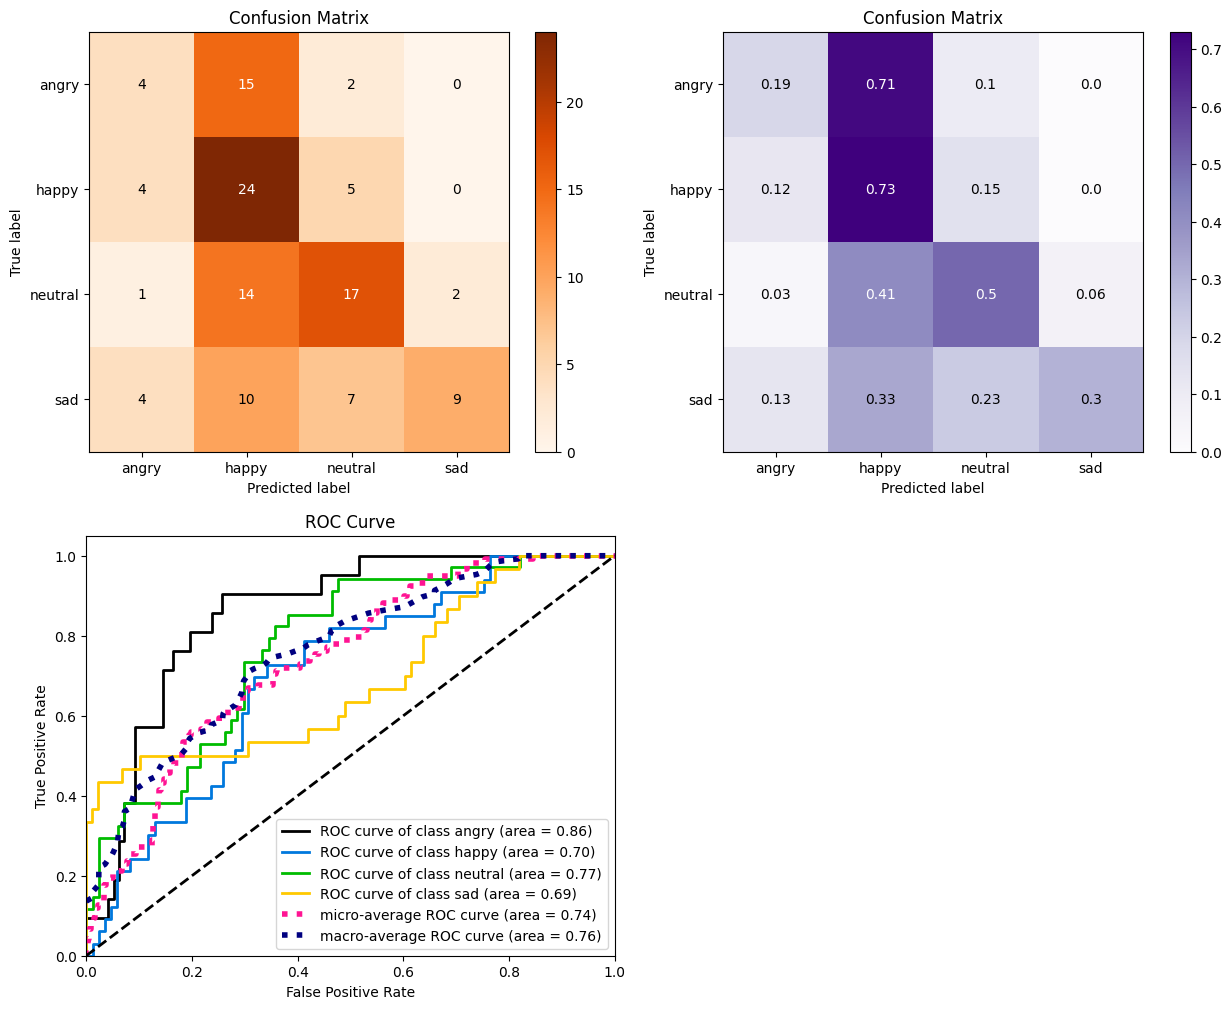

In [10]:
def plot_visualisations(y_true, y_pred, y_pred_probs):
    fig = plt.figure(figsize=(15,12))

    ax1 = fig.add_subplot(221)
    plot_confusion_matrix(y_true=y_true, y_pred=y_pred,
                            title="Confusion Matrix",
                            cmap="Oranges",
                            ax=ax1)

    ax2 = fig.add_subplot(222)
    plot_confusion_matrix(y_true=y_true, y_pred=y_pred,
                            normalize=True,
                            title="Confusion Matrix",
                            cmap="Purples",
                            ax=ax2)
    
    ax3 = fig.add_subplot(223)
    plot_roc_curve(y_true, y_pred_probs,
                    title="ROC Curve",
                    ax=ax3)

    plt.show()

pred_val_y_probs = model_svm.predict_proba(val_X_features)
plot_visualisations(val_y, pred_val_y, pred_val_y_probs)

#### Random Forest

In [22]:
# Train RandomForestClassifier

param_grid = {
    "n_estimators": np.arange(20, 101, 20),
    "max_depth": np.arange(10, 101, 10),
    "class_weight": ["balanced", "balanced_subsample", None],
}

model_rfc = RandomForestClassifier(random_state=4242)
model_rfc_cv = GridSearchCV(model_rfc, param_grid, cv=5, verbose=1)
model_rfc_cv.fit(train_X_features, train_y)

# Predict on validation set
pred_val_y = model_rfc_cv.predict(val_X_features)

# Evaluate metrics
rfc_accuracy, rfc_precision, rfc_recall, rfc_f1 = calculate_metrics(val_y, pred_val_y)

print(f"Best parameters: {model_rfc_cv.best_params_}")

results_df = pd.DataFrame({
    'Model': ['SVM', 'RandomForestClassifier'],
    'Accuracy': [svm_accuracy, rfc_accuracy],
    'Precision': [svm_precision, rfc_precision],
    'Recall': [svm_recall, rfc_recall],
    'F1': [svm_f1, rfc_f1]
})
results_df

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best parameters: {'class_weight': None, 'max_depth': 20, 'n_estimators': 100}


,Model,Accuracy,Precision,Recall,F1
0,SVM,0.457627,0.527318,0.457627,0.444038
1,RandomForestClassifier,0.864407,0.877450,0.864407,0.866654


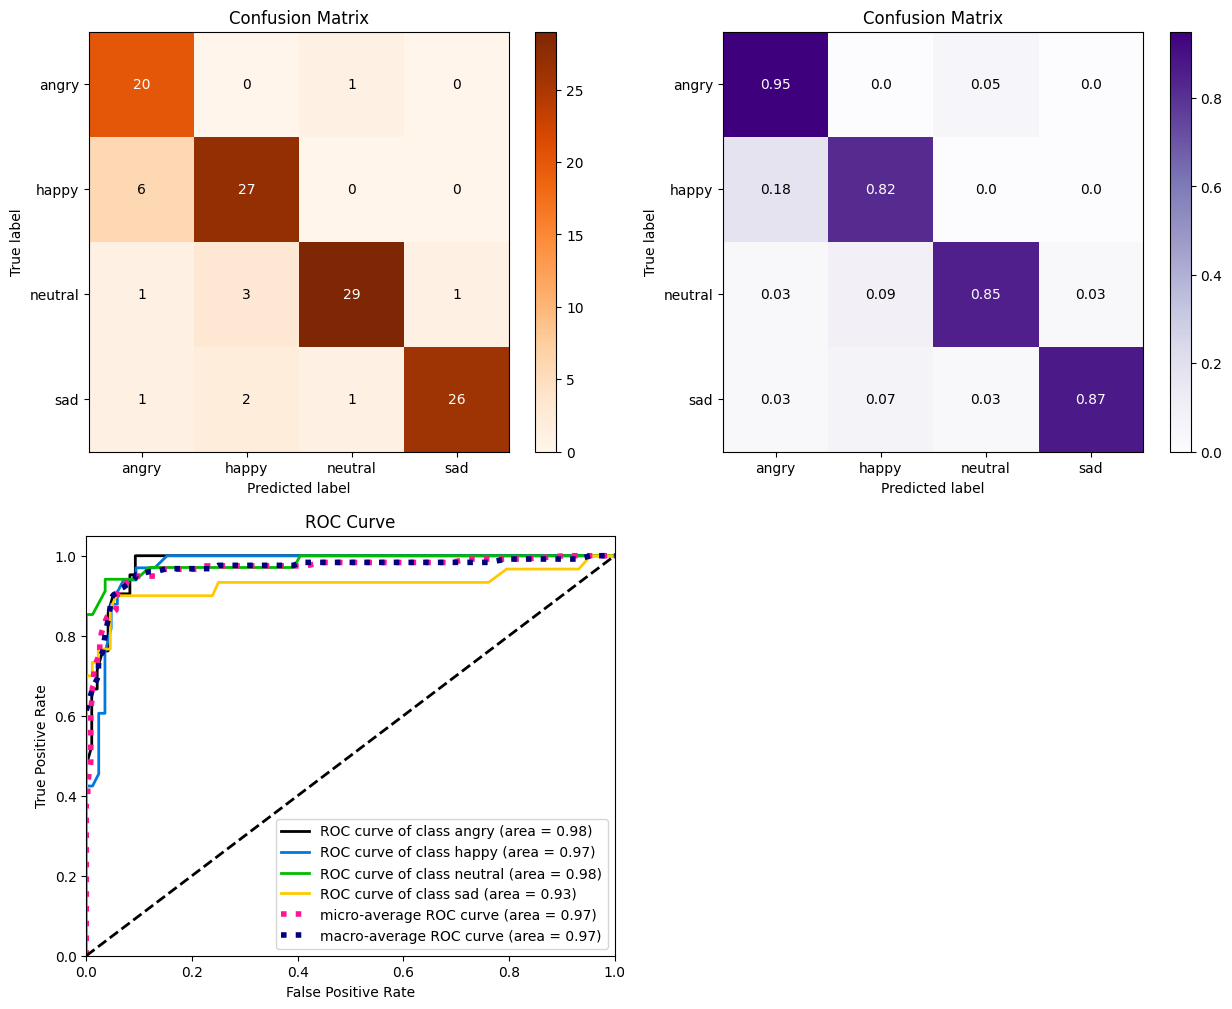

In [23]:
pred_val_y_probs = model_rfc_cv.predict_proba(val_X_features)
plot_visualisations(val_y, pred_val_y, pred_val_y_probs)

#### NN

In [25]:
# Neural Network

# Set hyperparameters
param_grid = {
    'hidden_layer_sizes': [(100, 50, 25)],
    'solver': ['adam', 'lbfgs'],
    'max_iter': np.arange(50, 301, 50),
    'learning_rate_init': np.arange(0.0005, 0.0021, 0.0005),
}


# Train model
model_nn = MLPClassifier(random_state=4242,
                         early_stopping=True,
                        #  verbose=True
                    )
model_nn_cv = GridSearchCV(model_nn, param_grid, cv=5, verbose=1)
model_nn_cv.fit(train_X_features, train_y)

# Predict on validation set
pred_val_y = model_nn_cv.predict(val_X_features)

# Evaluate metrics
nn_accuracy, nn_precision, nn_recall, nn_f1 = calculate_metrics(val_y, pred_val_y)

print(f"Best parameters: {model_nn_cv.best_params_}")

results_df = pd.DataFrame({
    'Model': ['SVM', 'RandomForestClassifier', 'MLPClassifier'],
    'Accuracy': [svm_accuracy, rfc_accuracy, nn_accuracy],
    'Precision': [svm_precision, rfc_precision, nn_precision],
    'Recall': [svm_recall, rfc_recall, nn_recall],
    'F1': [svm_f1, rfc_f1, nn_f1]
})
results_df

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'hidden_layer_sizes': (100, 50, 25), 'learning_rate_init': 0.0005, 'max_iter': 300, 'solver': 'lbfgs'}


,Model,Accuracy,Precision,Recall,F1
0,SVM,0.457627,0.527318,0.457627,0.444038
1,RandomForestClassifier,0.864407,0.877450,0.864407,0.866654
2,MLPClassifier,0.847458,0.857338,0.847458,0.848947


Iteration 1, loss = 16.79654737
Validation score: 0.333333
Iteration 2, loss = 12.50954713
Validation score: 0.208333
Iteration 3, loss = 10.29716573
Validation score: 0.208333
Iteration 4, loss = 7.53703953
Validation score: 0.354167
Iteration 5, loss = 6.12642497
Validation score: 0.375000
Iteration 6, loss = 5.10639778
Validation score: 0.375000
Iteration 7, loss = 3.37278601
Validation score: 0.208333
Iteration 8, loss = 2.33193973
Validation score: 0.229167
Iteration 9, loss = 1.88280179
Validation score: 0.229167
Iteration 10, loss = 2.02928368
Validation score: 0.250000
Iteration 11, loss = 1.99487617
Validation score: 0.354167
Iteration 12, loss = 1.72442785
Validation score: 0.437500
Iteration 13, loss = 1.48998631
Validation score: 0.458333
Iteration 14, loss = 1.36869134
Validation score: 0.458333
Iteration 15, loss = 1.42777309
Validation score: 0.520833
Iteration 16, loss = 1.16927169
Validation score: 0.562500
Iteration 17, loss = 1.15072931
Validation score: 0.583333
Ite

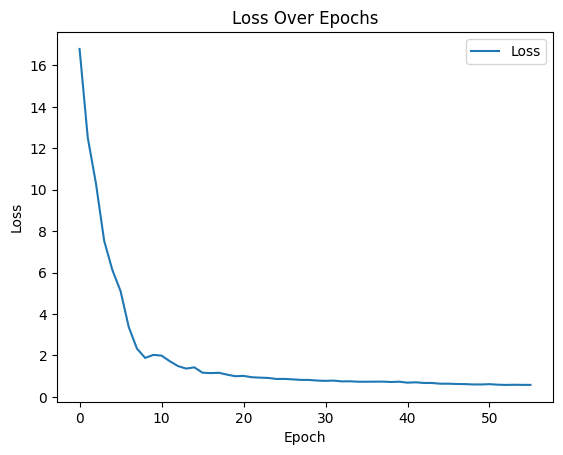

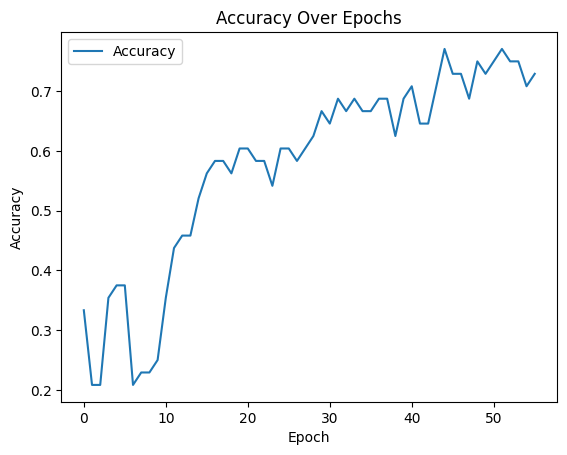

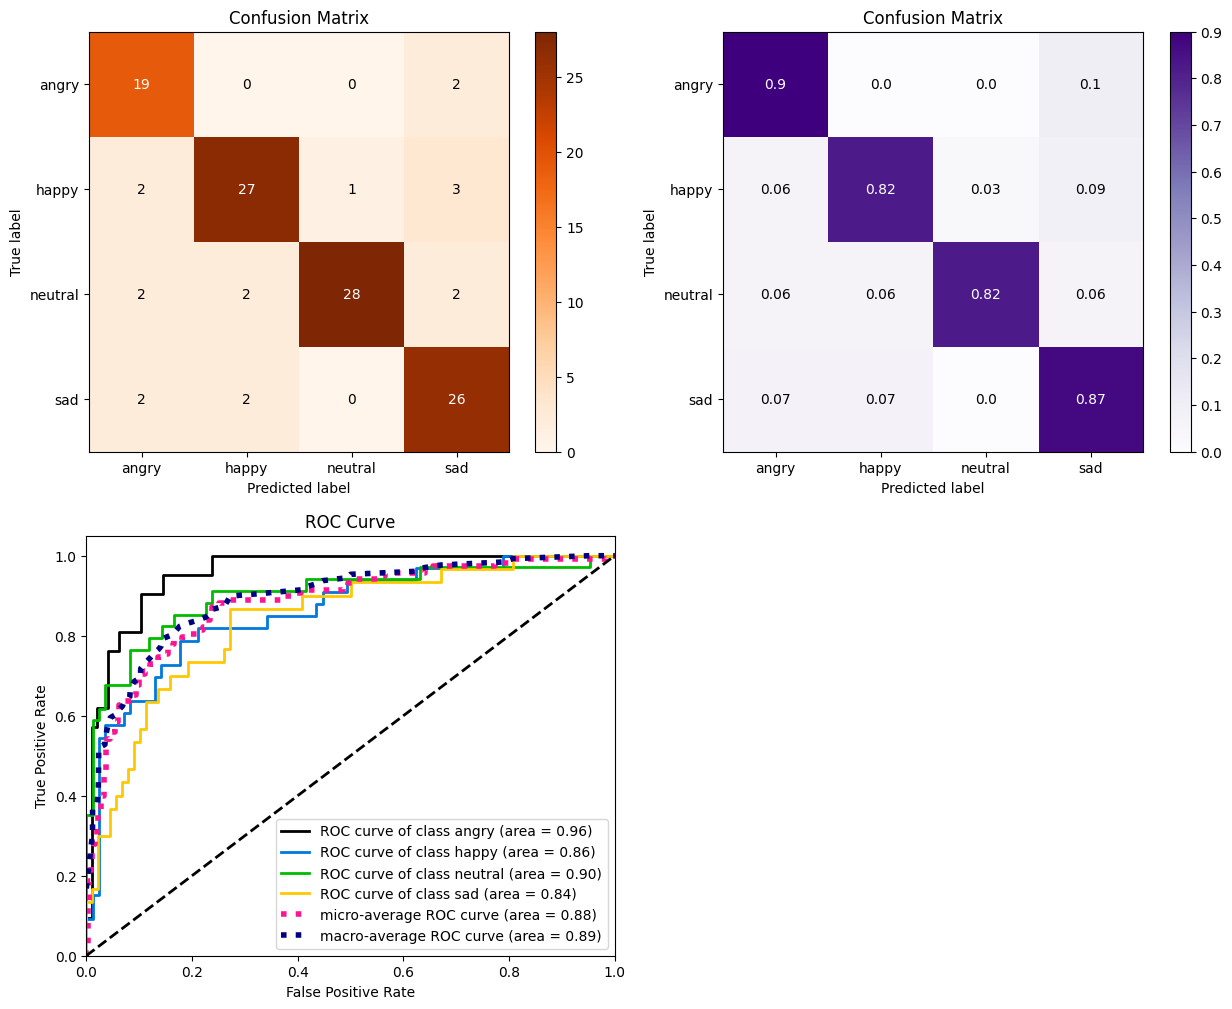

In [36]:
# Train model with best hyperparameters

model_nn_cv.best_params_['solver'] = 'adam'

# Doesnt work when solver is 'lbfgs', not sure why
model_nn_best = MLPClassifier(random_state=4242,
                                early_stopping=True,
                                verbose=True, 
                                **model_nn_cv.best_params_
                                )
model_nn_best.fit(train_X_features, train_y)

loss_curve = model_nn_best.loss_curve_
accuracy_curve = model_nn_best.validation_scores_

# Plot loss curve
plt.plot(loss_curve, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# Plot accuracy curve
plt.plot(accuracy_curve, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

pred_val_y_probs = model_nn_best.predict_proba(val_X_features)
plot_visualisations(val_y, pred_val_y, pred_val_y_probs)

#### k Nearest Neighbors

In [41]:
# k nearest neighbours

param_grid = {
    "n_neighbors": np.arange(1, 25),
    "metric": ["euclidean", "manhattan", "cosine"],
}

model_knn = KNeighborsClassifier()
model_knn_cv = GridSearchCV(model_knn, param_grid, cv=5)
model_knn_cv.fit(train_X_features, train_y)

# Predict on validation set
pred_val_y = model_knn_cv.predict(val_X_features)

# Evaluate metrics
knn_accuracy, knn_precision, knn_recall, knn_f1 = calculate_metrics(val_y, pred_val_y)

print(f"Best parameters: {model_knn_cv.best_params_}")

results_df = pd.DataFrame({
    'Model': ['SVM', 'RandomForestClassifier', 'MLPClassifier', 'KNeighborsClassifier'],
    'Accuracy': [svm_accuracy, rfc_accuracy, nn_accuracy, knn_accuracy],
    'Precision': [svm_precision, rfc_precision, nn_precision, knn_precision],
    'Recall': [svm_recall, rfc_recall, nn_recall, knn_recall],
    'F1': [svm_f1, rfc_f1, nn_f1, knn_f1]
})
results_df

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5}


,Model,Accuracy,Precision,Recall,F1
0,SVM,0.457627,0.527318,0.457627,0.444038
1,RandomForestClassifier,0.864407,0.877450,0.864407,0.866654
2,MLPClassifier,0.847458,0.857338,0.847458,0.848947
3,KNeighborsClassifier,0.906780,0.910788,0.906780,0.907594


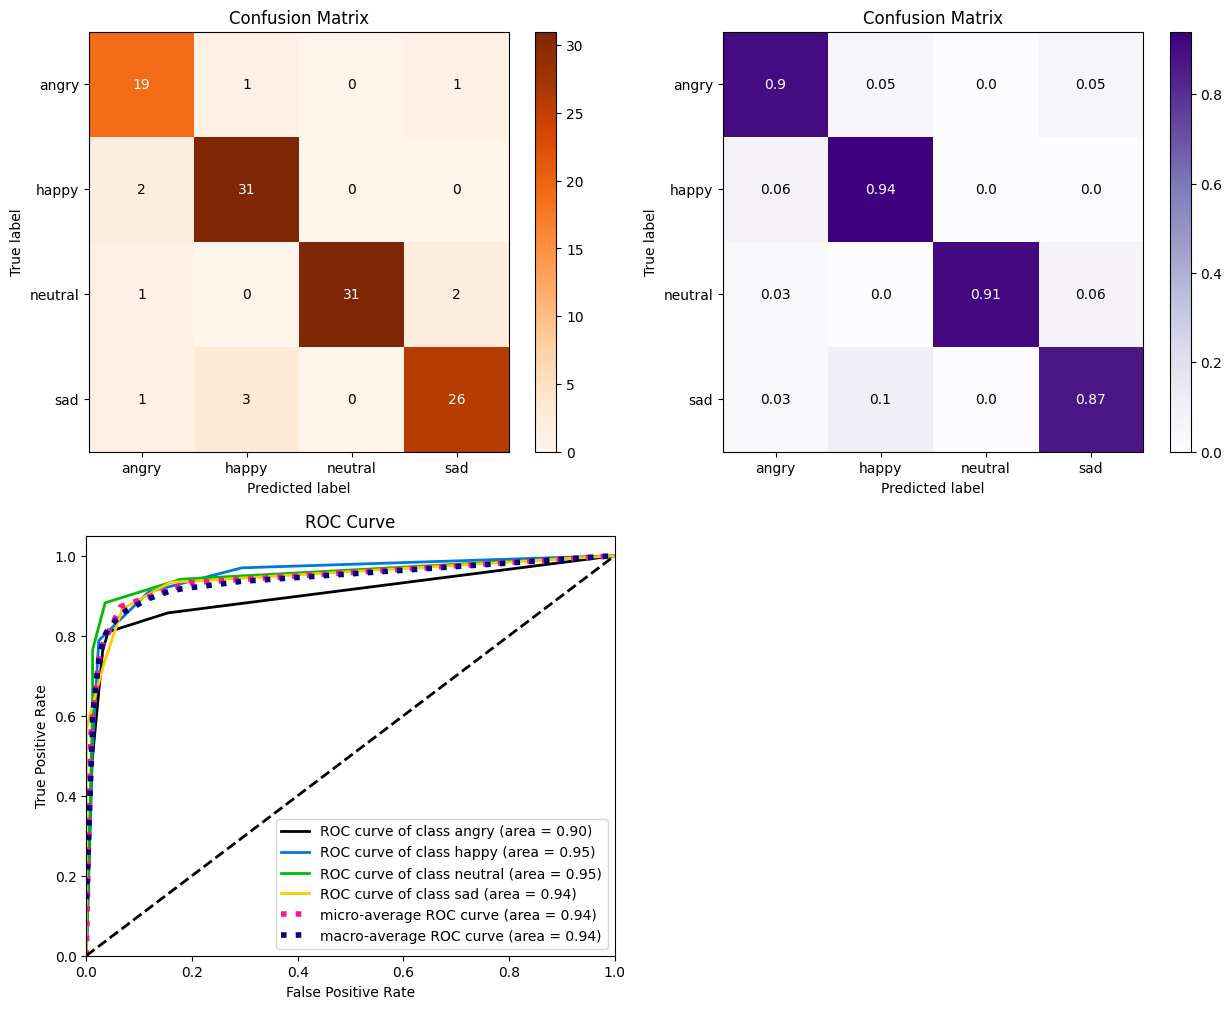

In [38]:
pred_val_y_probs = model_knn_cv.predict_proba(val_X_features)
plot_visualisations(val_y, pred_val_y, pred_val_y_probs)

#### Gradient Boosting Classifier

In [46]:
# Set hyperparameters

# param_grid = {
#     'learning_rate': np.arange(0.05, 0.21, 0.05),
#     'max_depth': np.arange(3, 8),
# }

param_grid = {
    'learning_rate': [0.1],
    'max_depth': np.arange(3, 5),
}

model_gbdt = GradientBoostingClassifier(random_state=4242)
model_gbdt_cv = GridSearchCV(model_gbdt, param_grid, cv=5, verbose=1)
model_gbdt_cv.fit(train_X_features, train_y)

# Predict on validation set
pred_val_y = model_gbdt_cv.predict(val_X_features)

# Evaluate metrics
gbdt_accuracy, gbdt_precision, gbdt_recall, gbdt_f1 = calculate_metrics(val_y, pred_val_y)

print(f"Best parameters: {model_gbdt_cv.best_params_}")

results_df = pd.DataFrame({
    'Model': ['SVM', 'RandomForestClassifier', 'MLPClassifier', 'KNeighborsClassifier', 'GradientBoosting'],
    'Accuracy': [svm_accuracy, rfc_accuracy, nn_accuracy, knn_accuracy, gbdt_accuracy],
    'Precision': [svm_precision, rfc_precision, nn_precision, knn_precision, gbdt_precision],
    'Recall': [svm_recall, rfc_recall, nn_recall, knn_recall, gbdt_recall],
    'F1': [svm_f1, rfc_f1, nn_f1, knn_f1, gbdt_f1]
})
results_df

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 4}


,Model,Accuracy,Precision,Recall,F1
0,SVM,0.457627,0.527318,0.457627,0.444038
1,RandomForestClassifier,0.864407,0.877450,0.864407,0.866654
2,MLPClassifier,0.847458,0.857338,0.847458,0.848947
3,KNeighborsClassifier,0.906780,0.910788,0.906780,0.907594
4,GradientBoosting,0.889831,0.902103,0.889831,0.891207


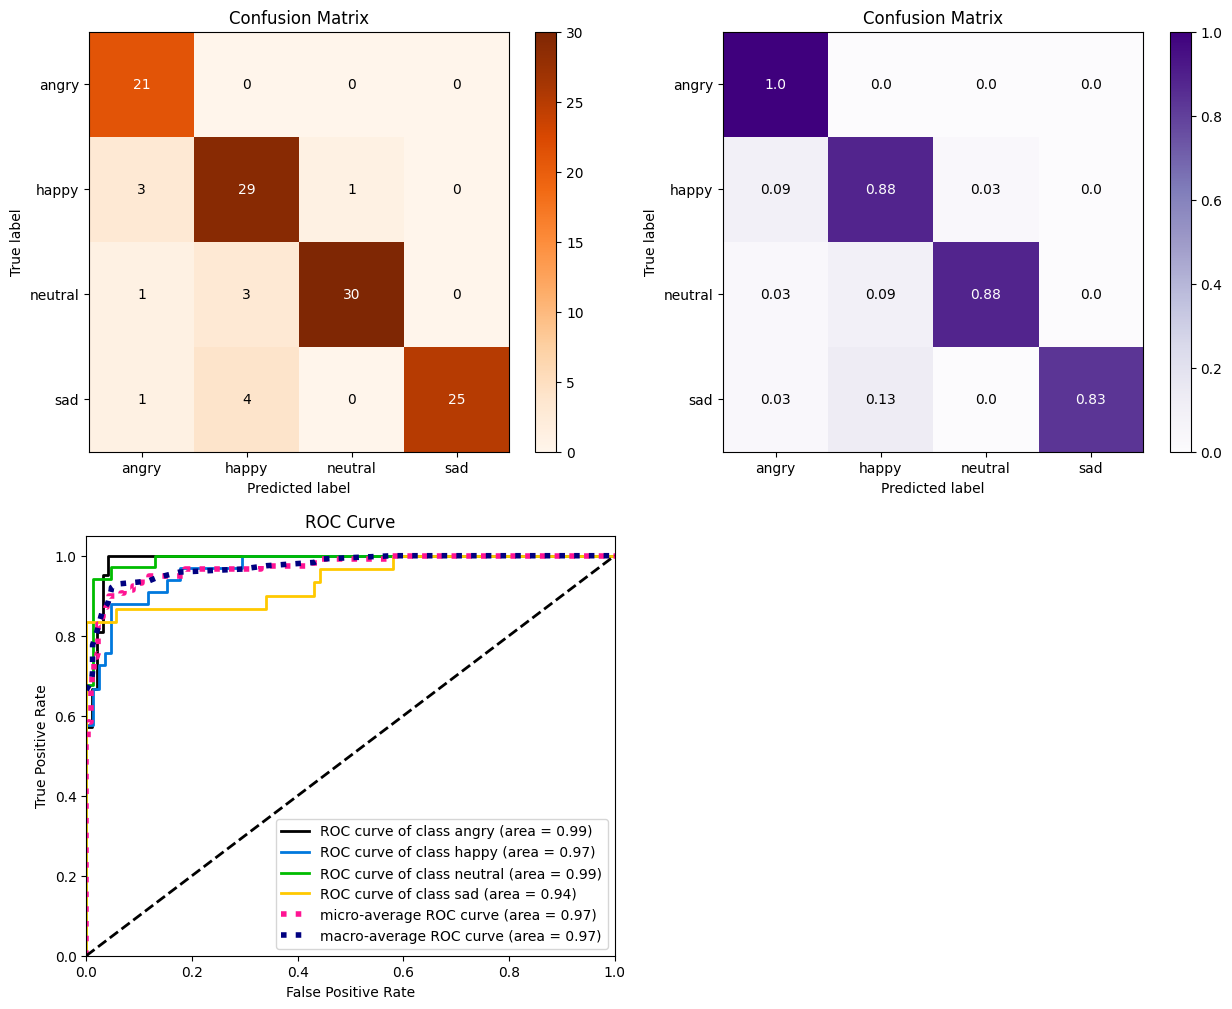

In [47]:
pred_val_y_probs = model_gbdt_cv.predict_proba(val_X_features)
plot_visualisations(val_y, pred_val_y, pred_val_y_probs)